## Vertical distribution of MHWs in the cape verde region

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import cmocean.cm as cmo
import scipy.signal as sig

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## jobqueue

In [3]:
import dask, dask_jobqueue
import dask.distributed as dask_distributed

In [4]:
cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34021 instead
  warnings.warn(


In [8]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          17346153      base dask-wor smomw379  R       0:22      1 nesh-srp198


In [9]:
client

<Client: 'tcp://172.18.4.21:42565' processes=4 threads=32, memory=74.52 GiB>

In [10]:
## load mask: host
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003/'
mask = xr.open_dataset(path+'atlantic_mask_3D.nc').squeeze()
ATLmask = mask.tmask.isel(X=range(750,1250),z=0).rename({'X':'x','Y':'y'})
ATLmask[852:,:] = 0 ## remove atlantic points outside nest domain
ATLmask[0:353,:] = 0 

path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/ORCA025.L46-KFS006-P-V/nemo/suppl/mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).rename({'z':'deptht'})

dpt = -dsM.nav_lev

## grid cell area
A = (dsM.e1t * dsM.e2t).where((ATLmask==1) & (dsM.tmask==1)).compute()

## depth of the sea-floor in the model
sfl = (dsM.e3t_0 * dsM.tmask).sum('deptht').compute()

In [11]:
#A = A.where(sfl>2000) ## Test whether points close to island have any impact on the results

In [12]:
def area_average(dsL, dsI, dsE, Ain, zz):
    ## area average: weigh by grid cell area so that subpolar latitudes have no larger contribution as there are more, but smaller grid points
    ## average of events (ignore grid points where no heatwaves occured)
    A = Ain.isel(deptht=zz)

    Area_averageL =  (dsL.where(dsL>0) * A).sum(('x','y')) / A.where(dsL>0).sum(('x','y'))
    Area_averageI =  (dsI.where(dsI>0) * A).sum(('x','y')) / A.where(dsI>0).sum(('x','y'))
    Area_averageE =  (dsE * A).sum(('x','y')) / A.sum(('x','y'))

    return Area_averageL, Area_averageI, Area_averageE

In [13]:
## cape verde region  14.5 - 17.5°N, 25.5°W - 22.5°W
yCV = range(554,575)
xCV = range(295,312) 

yCV_N = range(1002,1107) ## on nest grid 
xCV_N = range(1447,1532)

In [14]:
time = np.arange(1980,2023)

In [15]:
print(dsM.nav_lon.isel(x=xCV,y=yCV).min().values)
print(dsM.nav_lon.isel(x=xCV,y=yCV).max().values)

print(dsM.nav_lat.isel(x=xCV,y=yCV).min().values)
print(dsM.nav_lat.isel(x=xCV,y=yCV).max().values)


-26.0
-22.0
13.862732
18.661049


## All grid point average

In [16]:
Duration_z = np.zeros((43,46)); Intensity_z = np.zeros((43,46));  Freq_z = np.zeros((43,46)); 

Duration_z_lin = np.zeros((43,46)); Intensity_z_lin = np.zeros((43,46));  Freq_z_lin = np.zeros((43,46)); 



for zz in range(0,46):
    path ='/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/ANALYSIS/'

    if zz < 10:
        z = f'0{zz}'
    else:
        z=str(zz)

    # load clim WMO:
    pathC = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/Daily_Climatology/TMP/'
    dsCLIM = xr.open_mfdataset(pathC+f'VIKING20X.L46-KFS003-6th_dclim_19800101_20221231_votemper-WMO_1000-1249_500-749_{zz}.nc').isel(y=range(54,75), x=range(45,62))
    T_sigma = dsCLIM.sigma.where(dsCLIM.seas!=0)
    T_dif = (1.28*T_sigma).mean('doy')


    ## load data: WMO
    dsL_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Duration-WMO-{z}.nc').Duration_mn
    dsI_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_IntensityMax-WMO-{z}.nc').Intensity_max_mn
    dsE_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Events-WMO-{z}.nc').N_events

    ## area average
    Area_averageL, Area_averageI, Area_averageE =  area_average(dsL_00.isel(x=xCV,y=yCV),
                                                                dsI_00.isel(x=xCV,y=yCV) / T_dif, # scaled intensity
                                                                dsE_00.isel(x=xCV,y=yCV), 
                                                                A.isel(x=xCV,y=yCV), zz)

    Duration_z[:,zz]  = Area_averageL.where(Area_averageL!=0)
    Intensity_z[:,zz] = Area_averageI.where(Area_averageI!=0)
    Freq_z[:,zz]      = Area_averageE

    ## load data: detrend
    dsL_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Duration-detrend-{z}.nc').Duration_mn
    dsI_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_IntensityMax-detrend-{z}.nc').Intensity_max_mn
    dsE_00 = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Events-detrend-{z}.nc').N_events

    ## load clim: linear
    pathC = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/Daily_Climatology/TMP/'
    dsCLIM = xr.open_mfdataset(pathC+f'VIKING20X.L46-KFS003-6th_dclim_19800101_20221231_votemper-detrend_1000-1249_500-749_{zz}.nc').isel(y=range(54,75), x=range(45,62))
    T_sigma = dsCLIM.sigma.where(dsCLIM.seas!=0)
    T_dif = (1.28*T_sigma).mean('doy')

    ## area average
    Area_averageL_lin, Area_averageI_lin, Area_averageE_lin =  area_average(dsL_00.isel(x=xCV,y=yCV),
                                                                            dsI_00.isel(x=xCV,y=yCV) / T_dif, # scaled intensity 
                                                                            dsE_00.isel(x=xCV,y=yCV), 
                                                                            A.isel(x=xCV,y=yCV), zz)

    Duration_z_lin[:,zz]  = Area_averageL_lin.where(Area_averageL_lin!=0)
    Intensity_z_lin[:,zz] = Area_averageI_lin.where(Area_averageI_lin!=0)
    Freq_z_lin[:,zz]      = Area_averageE_lin

In [17]:
## calculate explained variance by surface values 
Freq_cor = np.zeros(46); Freq_corD = np.zeros(46); Freq_lin_cor = np.zeros(46)
Duration_cor = np.zeros(46); Duration_corD = np.zeros(46); Duration_lin_cor = np.zeros(46)
Intensity_cor = np.zeros(46); Intensity_corD = np.zeros(46); Intensity_lin_cor = np.zeros(46)

for z in range(0,46):
    Freq_cor[z] = np.corrcoef((np.nan_to_num(Freq_z.T[0,:],0), np.nan_to_num(Freq_z.T[z,:],0)))[0,1]
    Duration_cor[z] = np.corrcoef((np.nan_to_num(Duration_z.T[0,:],0), np.nan_to_num(Duration_z.T[z,:],0)))[0,1]
    Intensity_cor[z] = np.corrcoef((np.nan_to_num(Intensity_z.T[0,:],0), np.nan_to_num(Intensity_z.T[z,:],0)))[0,1]

    Freq_corD[z] = np.corrcoef(sig.detrend(np.nan_to_num(Freq_z.T[0,:],0)), sig.detrend(np.nan_to_num(Freq_z.T[z,:],0)))[0,1]
    Duration_corD[z] = np.corrcoef(sig.detrend(np.nan_to_num(Duration_z.T[0,:],0)), sig.detrend(np.nan_to_num(Duration_z.T[z,:],0)))[0,1]
    Intensity_corD[z] = np.corrcoef(sig.detrend(np.nan_to_num(Intensity_z.T[0,:],0)), sig.detrend(np.nan_to_num(Intensity_z.T[z,:],0)))[0,1]

    Freq_lin_cor[z] = np.corrcoef((np.nan_to_num(Freq_z_lin.T[0,:],0), np.nan_to_num(Freq_z_lin.T[z,:],0)))[0,1]
    Duration_lin_cor[z] = np.corrcoef((np.nan_to_num(Duration_z_lin.T[0,:],0), np.nan_to_num(Duration_z_lin.T[z,:],0)))[0,1]
    Intensity_lin_cor[z] = np.corrcoef((np.nan_to_num(Intensity_z_lin.T[0,:],0), np.nan_to_num(Intensity_z_lin.T[z,:],0)))[0,1]

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


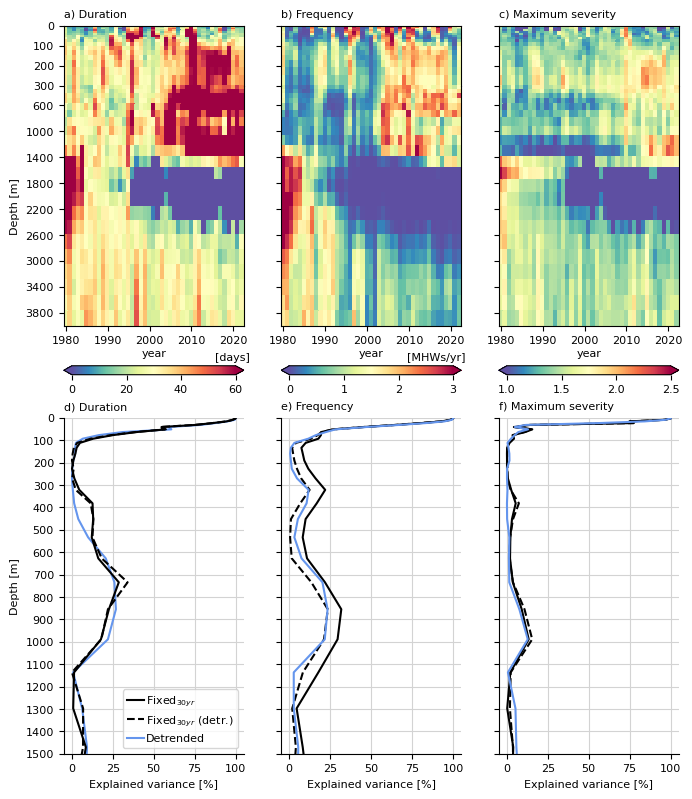

In [18]:
fig = plt.figure(figsize=(7.5,8))
ax1 = fig.add_axes([0.09,0.47,0.24,0.4]); ax1.spines[['top']].set_visible(False); ax11 = fig.add_axes([0.09,0.87,0.24,0.1]); ax11.set_xticks([]); ax11.spines[['bottom']].set_visible(False)
ax2 = fig.add_axes([0.38,0.47,0.24,0.4]); ax2.spines[['top']].set_visible(False); ax21 = fig.add_axes([0.38,0.87,0.24,0.1]); ax21.set_xticks([]); ax21.set_xticks([]); ax21.spines[['bottom']].set_visible(False)
ax3 = fig.add_axes([0.67,0.47,0.24,0.4]); ax3.spines[['top']].set_visible(False); ax31 = fig.add_axes([0.67,0.87,0.24,0.1]); ax31.set_xticks([]); ax31.set_xticks([]); ax31.spines[['bottom']].set_visible(False)

ax4 = fig.add_axes([0.09,0.06,0.24,0.42])
ax5 = fig.add_axes([0.38,0.06,0.24,0.42])
ax6 = fig.add_axes([0.67,0.06,0.24,0.42])

##
pc1 = ax1.pcolor(time, dpt, Duration_z.T, cmap='Spectral_r', vmin=0, vmax=60)
ax1.set_ylim(-4000,-300)
ax1.set_yticks(np.arange(-3800,-290,400))
ax1.set_yticklabels(np.arange(3800,290,-400))
ax1.set_ylabel('Depth [m]', fontsize=8)
ax1.set_xlabel('year', fontsize=8, labelpad=2)

ax11.pcolor(time, dpt, Duration_z.T, cmap='Spectral_r', vmin=0, vmax=60)
ax11.set_ylim(-300,0)
ax11.set_yticks(np.arange(-300,10,100))
ax11.set_yticklabels(np.arange(300,-10,-100))
ax11.set_title('a) Duration', loc='left', fontsize=8)

cb1=plt.colorbar(pc1, orientation='horizontal', ax=[ax1,ax11], extend='both', pad=0.1)
cb1.set_label('[days]', fontsize=8, x=0.98, labelpad=-30)

##
pc2 = ax2.pcolor(time, dpt, Freq_z.T, cmap='Spectral_r', vmin=0, vmax=3)

ax2.set_ylim(-4000,-300)
ax2.set_yticks(np.arange(-3800,-290,400))
ax2.set_yticklabels([])
ax2.set_xlabel('year', fontsize=8, labelpad=2)


ax21.pcolor(time, dpt, Freq_z.T, cmap='Spectral_r', vmin=0, vmax=3)
ax21.set_ylim(-300,0)
ax21.set_yticks(np.arange(-300,10,100))
ax21.set_yticklabels([])
ax21.set_title('b) Frequency', loc='left', fontsize=8)


cb2 = plt.colorbar(pc2, orientation='horizontal', ax=[ax2, ax21], extend='both', pad=0.1)
cb2.set_label('[MHWs/yr]', fontsize=8, x=.9, labelpad=-30)

##
pc3 = ax3.pcolor(time, dpt, Intensity_z.T, cmap='Spectral_r', vmin=1, vmax=2.5)

ax3.set_xlabel('year', fontsize=8, labelpad=2)
ax3.set_ylim(-4000,-300)
ax3.set_yticks(np.arange(-3800,-290,400))
ax3.set_yticklabels([])


ax31.pcolor(time, dpt, Intensity_z.T, cmap='Spectral_r', vmin=1, vmax=2.5)
ax31.set_ylim(-300,0)
ax31.set_yticks(np.arange(-300,10,100))
ax31.set_yticklabels([])
ax31.set_title('c) Maximum severity', loc='left', fontsize=8)

cb3 = plt.colorbar(pc3, orientation='horizontal', ax=[ax3, ax31], extend='both', pad=0.1)

##
ax4.plot(Duration_cor**2*100, dpt, zorder=10, color='k', lw=1.5, label=r'Fixed$_{30yr}$')
ax4.plot(Duration_corD**2*100, dpt, zorder=10, color='k', ls='--', lw=1.5, label=r'Fixed$_{30yr}$ (detr.)')
ax4.plot(Duration_lin_cor**2*100, dpt, color='cornflowerblue',lw=1.5, label='Detrended')

ax4.legend(fontsize=8, handlelength=1.5, handletextpad=0.2)
ax4.grid(True, color='lightgrey')
ax4.set_xticks(np.arange(0,105,25))
ax4.set_ylim(-1500,0)
ax4.set_yticks(np.arange(-1500,10,100))
ax4.set_yticklabels(np.arange(1500,-10,-100))

ax4.spines[['right', 'top']].set_visible(False)
ax4.set_xlabel('Explained variance [%]', fontsize=8)
ax4.set_ylabel('Depth [m]', fontsize=8)
ax4.set_title('d) Duration', loc='left', fontsize=8)

##
ax5.plot(Freq_cor**2*100, dpt, color='k', lw=1.5)
ax5.plot(Freq_corD**2*100, dpt, color='k', ls='--', lw=1.5)
ax5.plot(Freq_lin_cor**2*100, dpt, color='cornflowerblue',lw=1.5)

ax5.grid(True, color='lightgrey')
ax5.set_xticks(np.arange(0,105,25))
ax5.set_ylim(-1500,0)
ax5.set_yticks(np.arange(-1500,10,100))
ax5.set_yticklabels([]);
ax5.spines[['right', 'top']].set_visible(False)
ax5.set_xlabel('Explained variance [%]', fontsize=8)
ax5.set_title('e) Frequency', loc='left', fontsize=8)

##
ax6.plot(Intensity_cor**2*100, dpt, color='k', lw=1.5)
ax6.plot(Intensity_corD**2*100, dpt, color='k', ls='--', lw=1.5)
ax6.plot(Intensity_lin_cor**2*100, dpt, color='cornflowerblue',lw=1.5)

ax6.grid(True, color='lightgrey')
ax6.set_xticks(np.arange(0,105,25))
ax6.set_ylim(-1500,0)
ax6.set_yticks(np.arange(-1500,10,100))
ax6.set_yticklabels([]);
ax6.spines[['right', 'top']].set_visible(False)
ax6.set_xlabel('Explained variance [%]', fontsize=8)
ax6.set_title('f) Maximum severity', loc='left', fontsize=8)

plt.savefig('MHW-stats_CapeVerde.png', dpi=300)

## Save data for publication
* only store data that can not be derived from the annual mean MHW characteristics that are already stored

In [19]:
Intensity_z_lin_xr = xr.DataArray(Intensity_z_lin).rename({'dim_0':'year', 'dim_1':'deptht'})
Intensity_z_xr = xr.DataArray(Intensity_z).rename({'dim_0':'year', 'dim_1':'deptht'})

In [20]:
Intensity_z_lin_xr.attrs['units'] = 'None'
Intensity_z_lin_xr.attrs['long_name'] = 'Annual mean maximum severity in Cape Verde archipelago (detrended baseline)'

Intensity_z_xr.attrs['units'] = 'None'
Intensity_z_xr.attrs['long_name'] = 'Annual mean maximum severity in Cape Verde archipelago (fixed-30yr baseline)'

In [21]:
ds_out = xr.Dataset(data_vars={'Max_severity_lin':Intensity_z_lin_xr, 'Max_severity_WMO':Intensity_z_xr,
                                'year':np.arange(1980,2023), 'deptht':dsM.nav_lev})

In [22]:
## set global attributes
ds_out.attrs['title'] = 'Mixed layer depth and scaled intensity for Cape Verde archipelago'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 9_CapeVerde.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-07-31'
ds_out.attrs['date_modified'] = '2025-07-31'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [23]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure09.nc')